# Data-driven Modelling of Chlorophyll-a: Global Lakes

Data set taken from Naderian et al. (2024). "A water quality database for global lakes." Resources, Conservation & Recycling. 202, 107401.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import optuna
from optuna.samplers import TPESampler
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization._optimization_history import _get_optimization_history_info_list

from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct, Matern
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from time import time

data = pd.read_csv("Lake_Metadata.csv")
data["Country"] = data["Unique Lake"].str.slice(0, 3)
data.head()

,Unique ID,Unique Lake,sampledate,sample year,Latitude,Longitude,Depth Sample,Value Flags Chla,Chla,Value Flags TP,...,Value Flags DOS,DOS,DOC,TOC,TON,Value Flags TSS,TSS,Value Flags TFe,TFe,Country
0,ARG100114,ARG10016,19/03/2002,NaN,-31.3738,-64.439,18.0,NaN,0.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.40,ARG
1,ARG100117,ARG10016,19/03/2002,NaN,-31.3738,-64.439,16.0,NaN,0.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.11,ARG
2,ARG100123,ARG10016,22/01/2002,NaN,-31.3738,-64.439,15.0,NaN,0.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.39,ARG
3,ARG100128,ARG10016,18/12/2001,NaN,-31.3738,-64.439,16.0,NaN,0.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13,ARG
4,ARG100138,ARG10016,27/11/2001,NaN,-31.3738,-64.439,16.0,NaN,1.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.53,ARG


   Unique Lake   Chla      TP     TN    DO    TSS Country
14    CAN10339   2.70  100.00  400.0  0.00   2.00     CAN
15    UGA12564  16.80    0.10   30.0  0.04   3.33     UGA
49    UGA12564   4.80   71.30  220.0  0.19   0.80     UGA
52    UGA12564   4.80   66.00  160.0  0.20   2.00     UGA
53    UGA12564  10.91  105.17  170.0  0.23  13.33     UGA
(2128, 7)
Country
JPN    1759
UGA     247
CAN      76
USA      46
Name: count, dtype: int64


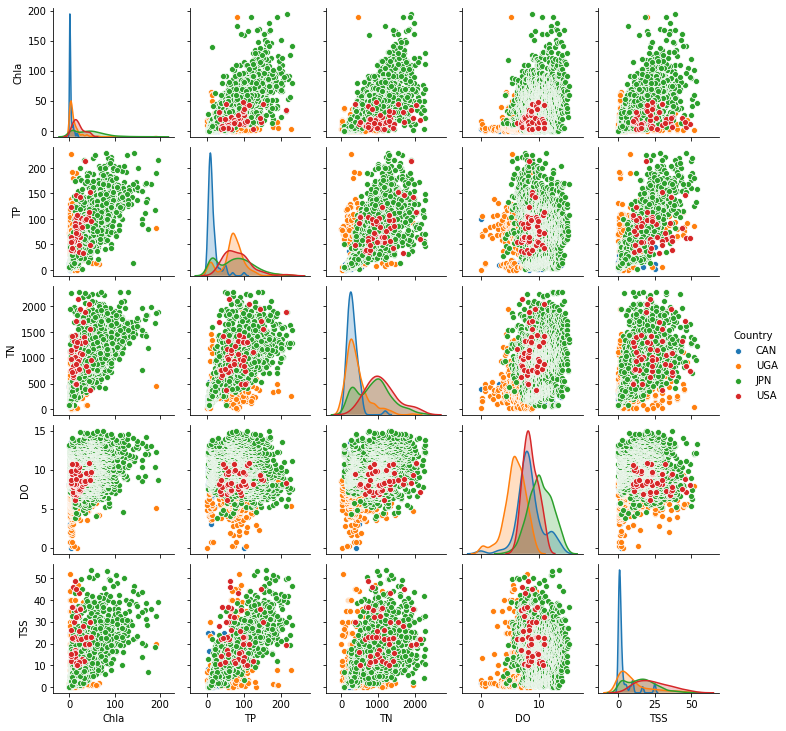

In [2]:
data2 = data.loc[data["Value Flags Chla"].isnull() & data["Value Flags TP"].isnull() & data["Value Flags TN"].isnull() \
                 & data["Value Flags DO"].isnull() & data["Value Flags TSS"].isnull(), \
                 ["Unique Lake", "Chla", "TP", "TN", "DO", "TSS", "Country"]]
data2.dropna(inplace=True)
data2 = data2.loc[(data2["Country"] == "JPN") | (data2["Country"] == "UGA") | \
                  (data2["Country"] == "USA") | (data2["Country"] == "CAN"), :]

# Remove outliers via 99% quantile
for col in np.arange(1, 6):
    q = data2.iloc[:, col].quantile(0.99)
    data2 = data2.loc[data2.iloc[:, col] < q, :]
    
print(data2.head())
print(data2.shape)
print(data2["Country"].value_counts())
sns.pairplot(data2.drop(columns="Unique Lake"), hue="Country", height=2)
plt.show()

      Unique Lake  Chla     TP      TN    DO    TSS Country
15170    JPN11042   0.3    5.0    80.0   9.9   0.27     JPN
21589    JPN11048  56.0  102.0  1800.0  13.7  21.50     JPN
14823    JPN11041  12.0   16.0   240.0   9.8   2.00     JPN
18018    JPN11048  58.0  117.0   793.0  11.0  21.60     JPN
21014    JPN11040  30.0   30.0   750.0  13.0   2.00     JPN
(400, 7)
Country
JPN    329
UGA     46
CAN     18
USA      7
Name: count, dtype: int64


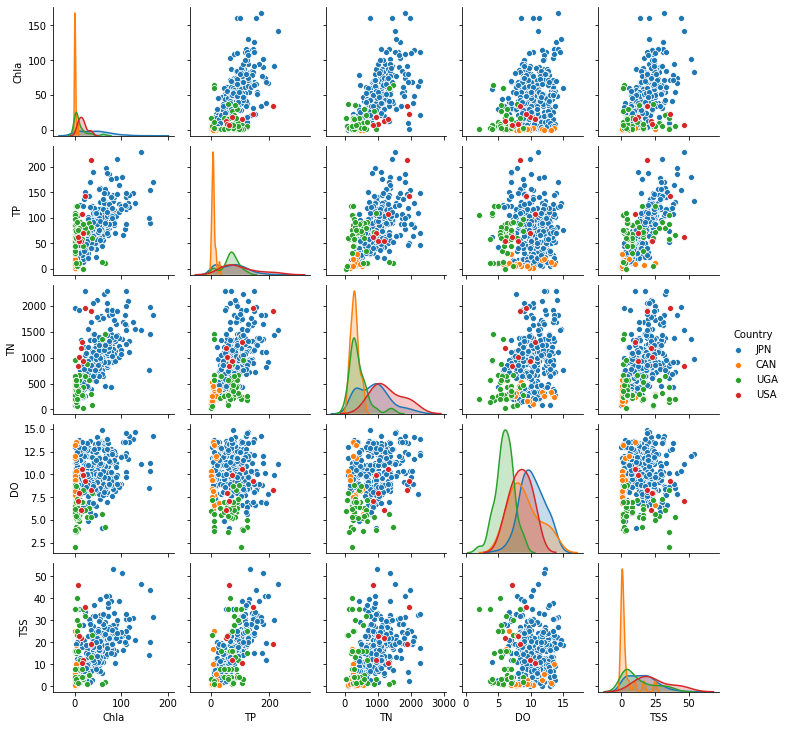

In [12]:
# Perform random downsampling to 400 points

np.random.seed(0)
idx = train_test_split(np.arange(len(data2)), train_size=400)
data3 = data2.iloc[idx[0], :]
print(data3.head())
print(data3.shape)
print(data3["Country"].value_counts())

sns.pairplot(data3.drop(columns="Unique Lake"), hue="Country", height=2)
plt.show()

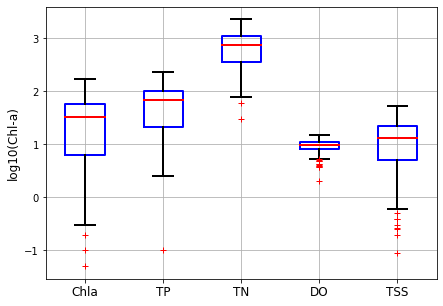

In [13]:
plt.figure(figsize=(7, 5))
plt.boxplot(np.log10(data3.iloc[:, 1:-1].to_numpy()), 
            boxprops=dict(linewidth=2, color='b'),
            medianprops=dict(linewidth=2, color='r'),
            whiskerprops=dict(linewidth=2, color='k'),
            capprops=dict(linewidth=2, color='k'),
            flierprops=dict(marker='+', markeredgecolor='r'))
plt.ylabel('log10(Chl-a)', fontsize=12)
plt.xticks(np.arange(data3.shape[1]-2)+1,
           labels=data3.columns.values[1:-1],
           fontsize=12)
plt.grid()
plt.show()

## Prepare Data for Modelling

In [14]:
X = data3.iloc[:, 2:-1].to_numpy()
y = data3.iloc[:, 1].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

scaler_X, scaler_y = StandardScaler(), StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)
print(X_train_scaled.shape)
print(y_train_scaled.shape)
print(X_test_scaled.shape)
print(y_test_scaled.shape)

(320, 4)
(320, 1)
(80, 4)
(80, 1)


## Baseline Linear Regression

R2 on Train Set: 0.6694236606699822
R2 on Test Set: 0.7165510502987045
Coefficients: 
 [4.13992867e-17] [[0.43794225 0.32395829 0.23569494 0.07401989]]
Coefficients for:
['TP' 'TN' 'DO' 'TSS']


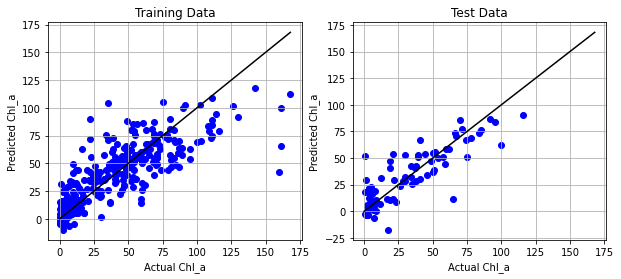

In [15]:
lin_mdl = LinearRegression().fit(X_train_scaled, y_train_scaled)
print(f"R2 on Train Set: {lin_mdl.score(X_train_scaled,y_train_scaled)}")
print(f"R2 on Test Set: {lin_mdl.score(X_test_scaled,y_test_scaled)}")
print("Coefficients: \n", lin_mdl.intercept_, lin_mdl.coef_)
print("Coefficients for:")
print(data3.columns.values[2:-1])

y_train_pred = scaler_y.inverse_transform(lin_mdl.predict(X_train_scaled))
y_test_pred = scaler_y.inverse_transform(lin_mdl.predict(X_test_scaled))

plt.subplots(ncols=2, figsize=(10, 4))
plt.subplot(121)
plt.scatter(y_train, y_train_pred, color='b')
plt.plot([0, np.max(y)],[0, np.max(y)],'k')
plt.xlabel('Actual Chl_a')
plt.ylabel('Predicted Chl_a')
plt.title('Training Data')
plt.grid()
plt.subplot(122)
plt.scatter(y_test, y_test_pred, color='b')
plt.plot([0, np.max(y)],[0, np.max(y)],'k')
plt.xlabel('Actual Chl_a')
plt.ylabel('Predicted Chl_a')
plt.title('Test Data')
plt.grid()
plt.show()

## Prediction of Chl-a using Optuna: Model Selection and Tuning

In [16]:
def create_model(trial, model_type):
    #model_type = trial.suggest_categorical('model_type', ['KRR', 'kNN', 'SVR', 'MLP', 'RF', 'GBR', 'GPR'])
    
    if model_type == 'KRR':
        alpha = trial.suggest_float('KRR_alpha',0.1, 100, log=True)
        kernel = trial.suggest_categorical('KRR_kernel',
                                           ['rbf', 'polynomial', 'cosine', 'laplacian', 'sigmoid'])
        gamma = trial.suggest_float('KRR_gamma',0.1, 10, log=True)
        model = KernelRidge(alpha=alpha, kernel=kernel, gamma=gamma)
        
    if model_type == 'kNN':
        wts = trial.suggest_categorical('kNN_weights', ['uniform', 'distance'])
        n_neigh = trial.suggest_int('kNN_n_neighbors',1,20)
        model = KNeighborsRegressor(weights=wts,n_neighbors=n_neigh)
    
    if model_type == 'SVR':
        kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        C = trial.suggest_float('SVR-C', 0.1, 100, log=True)
        gamma = trial.suggest_float('SVR-gamma', 0.1, 10, log=True)
        epsi = trial.suggest_float('SVR-epsilon', 0.1, 10, log=True)
        degree = trial.suggest_int('SVR-degree', 1, 2, step=1)
        model = SVR(kernel=kernel, C=C, epsilon=epsi, gamma=gamma, degree=degree)
    
    if model_type == 'MLP':
        params = {
                    'learning_rate_init': trial.suggest_float('learning_rate_init ', 0.0001, 0.1, log=True),
                    'first_layer_neurons': trial.suggest_int('first_layer_neurons', 10, 100, step=1),
                    'second_layer_neurons': trial.suggest_int('second_layer_neurons', 10, 100, step=1),
                    'activation': trial.suggest_categorical('activation', ['identity', 'tanh', 'relu']),
                 }

        model = MLPRegressor(hidden_layer_sizes=(params['first_layer_neurons'], params['second_layer_neurons']),
                             learning_rate_init=params['learning_rate_init'],
                             activation=params['activation'],
                             random_state=1,
                             max_iter=100)
        
    if model_type == 'RF':
        n_estimators = trial.suggest_int('RF_n_estimators',10,200)
        crit = trial.suggest_categorical('RF_criterion', ['friedman_mse', 'squared_error', 'absolute_error'])
        max_depth = trial.suggest_int('RF_max_depth',1,50)
        model = RandomForestRegressor(n_estimators=n_estimators, 
                                      criterion=crit, 
                                      max_depth=max_depth,
                                      random_state=42)
        
    if model_type == 'GBR':
        n_estimators = trial.suggest_int('GBR_n_estimators',10,200)
        max_depth = trial.suggest_int('GBR_max_depth',1,50)
        model = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth)
        
    if model_type == 'GPR':
        alpha = trial.suggest_float('GPR_alpha',0.01, 100, log=True)
        noise_level = trial.suggest_float('GPR_noise',0.01, 10, log=True)
        kernel_type = trial.suggest_categorical('GPR_kernel', ['rbf','matern','dot'])
        if kernel_type == 'rbf':
            length_scale = trial.suggest_float('GPR_length_scale',0.01, 10, log=True)
            model = GaussianProcessRegressor(kernel=WhiteKernel(noise_level) + RBF(length_scale=length_scale),
                                             alpha=alpha,
                                             normalize_y=False, 
                                             n_restarts_optimizer=10)
        if kernel_type == 'matern':
            length_scale = trial.suggest_float('GPR_length_scale',0.01, 10, log=True)
            nu = trial.suggest_float('GP_nu',0.5, 5, step=0.5)
            model = GaussianProcessRegressor(kernel=WhiteKernel(noise_level) + Matern(length_scale=length_scale,nu=nu),
                                             alpha=alpha,
                                             normalize_y=False, 
                                             n_restarts_optimizer=10)
        if kernel_type == 'dot':
            sigma = trial.suggest_float('GPR_dot_sigma', 0, 10)
            model = GaussianProcessRegressor(kernel=WhiteKernel(noise_level) + DotProduct(sigma_0=sigma),
                                             alpha=alpha,
                                             normalize_y=False, 
                                             n_restarts_optimizer=10)

    if trial.should_prune():
            raise optuna.TrialPruned()

    return model

def objective(trial, model_type):
    model = create_model(trial, model_type)
    scores = cross_val_score(model, 
                             X_train_scaled, 
                             y_train_scaled.ravel(), 
                             cv=5,
                             scoring='neg_mean_squared_error')
    return np.mean(scores)


sampler = TPESampler(seed=42)
best_mdls = []
studies = []
for model_type in ['KRR', 'kNN', 'SVR', 'MLP', 'RF', 'GBR', 'GPR']:
#for model_type in ['KRR']:
    study = optuna.create_study(direction='maximize', 
                                sampler=sampler)
    optuna_start = time()
    study.optimize(lambda trial: objective(trial, model_type), n_trials=100, 
                   gc_after_trial=True)
    studies.append(study)
    best_params = study.best_params
    print("\n\nBest parameters: ", best_params)
    total_time = time()-optuna_start
    print("Runtime: %.4f sec" % total_time)
    best_mdls.append(create_model(study.best_trial, model_type))

[I 2024-11-05 23:50:43,483] A new study created in memory with name: no-name-2b0b26e3-1c19-4f5b-8b0a-0d5942377fa5
[I 2024-11-05 23:50:43,519] Trial 0 finished with value: -0.3066070737797747 and parameters: {'KRR_alpha': 1.3292918943162166, 'KRR_kernel': 'rbf', 'KRR_gamma': 0.13066739238053282}. Best is trial 0 with value: -0.3066070737797747.
[I 2024-11-05 23:50:43,660] Trial 1 finished with value: -0.5812407339958291 and parameters: {'KRR_alpha': 39.67605077052987, 'KRR_kernel': 'laplacian', 'KRR_gamma': 0.26587543983272705}. Best is trial 0 with value: -0.3066070737797747.
[I 2024-11-05 23:50:43,749] Trial 2 finished with value: -0.3889742996184391 and parameters: {'KRR_alpha': 0.3511356313970407, 'KRR_kernel': 'cosine', 'KRR_gamma': 1.6738085788752133}. Best is trial 0 with value: -0.3066070737797747.
[I 2024-11-05 23:50:43,833] Trial 3 finished with value: -0.4032443928161336 and parameters: {'KRR_alpha': 0.262108787826544, 'KRR_kernel': 'laplacian', 'KRR_gamma': 1.067748270948135

[I 2024-11-05 23:50:47,779] Trial 33 finished with value: -0.30333701561090837 and parameters: {'KRR_alpha': 1.3778673044641274, 'KRR_kernel': 'polynomial', 'KRR_gamma': 0.12588823962165693}. Best is trial 28 with value: -0.2976894509554601.
[I 2024-11-05 23:50:47,888] Trial 34 finished with value: -0.38927714769553784 and parameters: {'KRR_alpha': 3.422285230442237, 'KRR_kernel': 'cosine', 'KRR_gamma': 0.2988092072471754}. Best is trial 28 with value: -0.2976894509554601.
[I 2024-11-05 23:50:48,133] Trial 35 finished with value: -1.6918307360815406 and parameters: {'KRR_alpha': 1.9871782886417362, 'KRR_kernel': 'sigmoid', 'KRR_gamma': 0.1880253166528913}. Best is trial 28 with value: -0.2976894509554601.
[I 2024-11-05 23:50:48,248] Trial 36 finished with value: -0.41371867287304137 and parameters: {'KRR_alpha': 12.124607612535073, 'KRR_kernel': 'laplacian', 'KRR_gamma': 0.1338960182337515}. Best is trial 28 with value: -0.2976894509554601.
[I 2024-11-05 23:50:48,392] Trial 37 finished

[I 2024-11-05 23:50:52,366] Trial 66 finished with value: -0.32398790537367494 and parameters: {'KRR_alpha': 2.7863764919055947, 'KRR_kernel': 'rbf', 'KRR_gamma': 0.1671957701491702}. Best is trial 28 with value: -0.2976894509554601.
[I 2024-11-05 23:50:52,631] Trial 67 finished with value: -1.0835576052658662 and parameters: {'KRR_alpha': 5.781001028132936, 'KRR_kernel': 'sigmoid', 'KRR_gamma': 0.18899628846706867}. Best is trial 28 with value: -0.2976894509554601.
[I 2024-11-05 23:50:52,766] Trial 68 finished with value: -0.30133374985910966 and parameters: {'KRR_alpha': 2.1907301432441826, 'KRR_kernel': 'polynomial', 'KRR_gamma': 0.13675845304999673}. Best is trial 28 with value: -0.2976894509554601.
[I 2024-11-05 23:50:52,948] Trial 69 finished with value: -0.30129153778684536 and parameters: {'KRR_alpha': 7.493101161885081, 'KRR_kernel': 'polynomial', 'KRR_gamma': 0.11638808848183829}. Best is trial 28 with value: -0.2976894509554601.
[I 2024-11-05 23:50:53,083] Trial 70 finished 

[I 2024-11-05 23:50:56,955] Trial 99 finished with value: -0.2992461733850754 and parameters: {'KRR_alpha': 5.086898821634236, 'KRR_kernel': 'polynomial', 'KRR_gamma': 0.11056261314740623}. Best is trial 28 with value: -0.2976894509554601.
[I 2024-11-05 23:50:57,034] A new study created in memory with name: no-name-23d68464-43c1-457f-b1d6-c5af27e240ca
[I 2024-11-05 23:50:57,034] Trial 0 finished with value: -0.6858881044182056 and parameters: {'kNN_weights': 'uniform', 'kNN_n_neighbors': 1}. Best is trial 0 with value: -0.6858881044182056.
[I 2024-11-05 23:50:57,114] Trial 1 finished with value: -0.329735683501332 and parameters: {'kNN_weights': 'uniform', 'kNN_n_neighbors': 15}. Best is trial 1 with value: -0.329735683501332.
[I 2024-11-05 23:50:57,218] Trial 2 finished with value: -0.3415759621255774 and parameters: {'kNN_weights': 'uniform', 'kNN_n_neighbors': 8}. Best is trial 1 with value: -0.329735683501332.




Best parameters:  {'KRR_alpha': 2.7695703289883373, 'KRR_kernel': 'polynomial', 'KRR_gamma': 0.10037327015001402}
Runtime: 13.5498 sec


[I 2024-11-05 23:50:57,296] Trial 3 finished with value: -0.32974627643337034 and parameters: {'kNN_weights': 'distance', 'kNN_n_neighbors': 13}. Best is trial 1 with value: -0.329735683501332.
[I 2024-11-05 23:50:57,390] Trial 4 finished with value: -0.3518829163699656 and parameters: {'kNN_weights': 'uniform', 'kNN_n_neighbors': 7}. Best is trial 1 with value: -0.329735683501332.
[I 2024-11-05 23:50:57,469] Trial 5 finished with value: -0.32974627643337034 and parameters: {'kNN_weights': 'distance', 'kNN_n_neighbors': 13}. Best is trial 1 with value: -0.329735683501332.
[I 2024-11-05 23:50:57,547] Trial 6 finished with value: -0.41745305412823697 and parameters: {'kNN_weights': 'uniform', 'kNN_n_neighbors': 3}. Best is trial 1 with value: -0.329735683501332.
[I 2024-11-05 23:50:57,625] Trial 7 finished with value: -0.3334633034591778 and parameters: {'kNN_weights': 'distance', 'kNN_n_neighbors': 12}. Best is trial 1 with value: -0.329735683501332.
[I 2024-11-05 23:50:57,703] Trial 8 

[I 2024-11-05 23:51:00,974] Trial 43 finished with value: -0.32626799117732963 and parameters: {'kNN_weights': 'distance', 'kNN_n_neighbors': 19}. Best is trial 14 with value: -0.3252752152062705.
[I 2024-11-05 23:51:01,045] Trial 44 finished with value: -0.33041686575500884 and parameters: {'kNN_weights': 'distance', 'kNN_n_neighbors': 15}. Best is trial 14 with value: -0.3252752152062705.
[I 2024-11-05 23:51:01,123] Trial 45 finished with value: -0.33080281170055825 and parameters: {'kNN_weights': 'uniform', 'kNN_n_neighbors': 12}. Best is trial 14 with value: -0.3252752152062705.
[I 2024-11-05 23:51:01,201] Trial 46 finished with value: -0.32626799117732963 and parameters: {'kNN_weights': 'distance', 'kNN_n_neighbors': 19}. Best is trial 14 with value: -0.3252752152062705.
[I 2024-11-05 23:51:01,282] Trial 47 finished with value: -0.6858881044182056 and parameters: {'kNN_weights': 'uniform', 'kNN_n_neighbors': 1}. Best is trial 14 with value: -0.3252752152062705.
[I 2024-11-05 23:51

[I 2024-11-05 23:51:04,436] Trial 83 finished with value: -0.32765069332758234 and parameters: {'kNN_weights': 'uniform', 'kNN_n_neighbors': 18}. Best is trial 14 with value: -0.3252752152062705.
[I 2024-11-05 23:51:04,521] Trial 84 finished with value: -0.3252752152062705 and parameters: {'kNN_weights': 'uniform', 'kNN_n_neighbors': 17}. Best is trial 14 with value: -0.3252752152062705.
[I 2024-11-05 23:51:04,611] Trial 85 finished with value: -0.32611857751296847 and parameters: {'kNN_weights': 'uniform', 'kNN_n_neighbors': 16}. Best is trial 14 with value: -0.3252752152062705.
[I 2024-11-05 23:51:04,696] Trial 86 finished with value: -0.32694626249191855 and parameters: {'kNN_weights': 'uniform', 'kNN_n_neighbors': 19}. Best is trial 14 with value: -0.3252752152062705.
[I 2024-11-05 23:51:04,773] Trial 87 finished with value: -0.33485648833833775 and parameters: {'kNN_weights': 'uniform', 'kNN_n_neighbors': 11}. Best is trial 14 with value: -0.3252752152062705.
[I 2024-11-05 23:51:0



Best parameters:  {'kNN_weights': 'uniform', 'kNN_n_neighbors': 17}
Runtime: 8.9474 sec


[I 2024-11-05 23:51:06,191] Trial 1 finished with value: -1.757904595962596 and parameters: {'kernel': 'rbf', 'SVR-C': 61.53085601625307, 'SVR-gamma': 4.132765459466365, 'SVR-epsilon': 1.8484491720988625, 'SVR-degree': 2}. Best is trial 0 with value: -0.9820032381075677.
[I 2024-11-05 23:51:06,286] Trial 2 finished with value: -0.6817585475761316 and parameters: {'kernel': 'rbf', 'SVR-C': 26.44359307839864, 'SVR-gamma': 6.197015748809146, 'SVR-epsilon': 0.432520752538653, 'SVR-degree': 1}. Best is trial 2 with value: -0.6817585475761316.
[I 2024-11-05 23:51:06,390] Trial 3 finished with value: -6.170894196942191 and parameters: {'kernel': 'sigmoid', 'SVR-C': 0.10491954332267911, 'SVR-gamma': 1.05073840241814, 'SVR-epsilon': 0.6836314065022723, 'SVR-degree': 1}. Best is trial 2 with value: -0.6817585475761316.
[I 2024-11-05 23:51:06,484] Trial 4 finished with value: -0.582106889714907 and parameters: {'kernel': 'rbf', 'SVR-C': 3.6005750292009013, 'SVR-gamma': 2.5470526233391175, 'SVR-ep

[I 2024-11-05 23:54:37,235] Trial 30 finished with value: -1.0285824242603838 and parameters: {'kernel': 'poly', 'SVR-C': 47.47653971993011, 'SVR-gamma': 7.307691367858495, 'SVR-epsilon': 0.14111872491684468, 'SVR-degree': 2}. Best is trial 26 with value: -0.34307550920179564.
[I 2024-11-05 23:54:37,639] Trial 31 finished with value: -0.3444688002769338 and parameters: {'kernel': 'linear', 'SVR-C': 42.79279407560489, 'SVR-gamma': 7.032164193585391, 'SVR-epsilon': 0.1025983428746464, 'SVR-degree': 2}. Best is trial 26 with value: -0.34307550920179564.
[I 2024-11-05 23:54:38,117] Trial 32 finished with value: -0.34518849941666063 and parameters: {'kernel': 'linear', 'SVR-C': 60.977982707835096, 'SVR-gamma': 7.778405960739135, 'SVR-epsilon': 0.15242785719425248, 'SVR-degree': 2}. Best is trial 26 with value: -0.34307550920179564.
[I 2024-11-05 23:54:38,316] Trial 33 finished with value: -0.34338172277418544 and parameters: {'kernel': 'linear', 'SVR-C': 22.37240886248133, 'SVR-gamma': 5.36

[I 2024-11-05 23:54:43,931] Trial 59 finished with value: -0.34870952921360115 and parameters: {'kernel': 'linear', 'SVR-C': 17.863627483721725, 'SVR-gamma': 3.441125484529764, 'SVR-epsilon': 0.5518585083656711, 'SVR-degree': 1}. Best is trial 54 with value: -0.3407134001330222.
[I 2024-11-05 23:54:44,094] Trial 60 finished with value: -0.34461919049052525 and parameters: {'kernel': 'linear', 'SVR-C': 12.900970710978125, 'SVR-gamma': 2.517105711323397, 'SVR-epsilon': 0.294211160808926, 'SVR-degree': 1}. Best is trial 54 with value: -0.3407134001330222.
[I 2024-11-05 23:54:44,273] Trial 61 finished with value: -0.34295289312154775 and parameters: {'kernel': 'linear', 'SVR-C': 32.76473350479414, 'SVR-gamma': 2.1602800220357223, 'SVR-epsilon': 0.47557112392736123, 'SVR-degree': 1}. Best is trial 54 with value: -0.3407134001330222.
[I 2024-11-05 23:54:44,502] Trial 62 finished with value: -0.34214335734047086 and parameters: {'kernel': 'linear', 'SVR-C': 36.874694686098024, 'SVR-gamma': 1.

[I 2024-11-05 23:54:51,693] Trial 88 finished with value: -0.3486386595149057 and parameters: {'kernel': 'linear', 'SVR-C': 50.771721146750224, 'SVR-gamma': 6.485929208037222, 'SVR-epsilon': 0.5341117155822018, 'SVR-degree': 1}. Best is trial 54 with value: -0.3407134001330222.
[I 2024-11-05 23:54:51,909] Trial 89 finished with value: -0.34142570712124365 and parameters: {'kernel': 'linear', 'SVR-C': 25.95948084752786, 'SVR-gamma': 3.2000709215947123, 'SVR-epsilon': 0.43140325947636465, 'SVR-degree': 1}. Best is trial 54 with value: -0.3407134001330222.
[I 2024-11-05 23:54:52,027] Trial 90 finished with value: -781956.9966614747 and parameters: {'kernel': 'sigmoid', 'SVR-C': 25.548603619486588, 'SVR-gamma': 3.220205072965586, 'SVR-epsilon': 0.44650470044801305, 'SVR-degree': 1}. Best is trial 54 with value: -0.3407134001330222.
[I 2024-11-05 23:54:52,212] Trial 91 finished with value: -0.34586782237002384 and parameters: {'kernel': 'linear', 'SVR-C': 31.386776981840562, 'SVR-gamma': 4.



Best parameters:  {'kernel': 'linear', 'SVR-C': 28.309720277666, 'SVR-gamma': 2.5775432526997486, 'SVR-epsilon': 0.423561235818907, 'SVR-degree': 1}
Runtime: 228.2112 sec


[I 2024-11-05 23:54:54,438] Trial 0 finished with value: -0.3501267886729019 and parameters: {'learning_rate_init ': 0.0010548702714918063, 'first_layer_neurons': 20, 'second_layer_neurons': 94, 'activation': 'identity'}. Best is trial 0 with value: -0.3501267886729019.
[I 2024-11-05 23:54:55,344] Trial 1 finished with value: -0.38881630067904305 and parameters: {'learning_rate_init ': 0.028292192255361892, 'first_layer_neurons': 60, 'second_layer_neurons': 58, 'activation': 'relu'}. Best is trial 0 with value: -0.3501267886729019.
[I 2024-11-05 23:54:56,028] Trial 2 finished with value: -0.3740410384509525 and parameters: {'learning_rate_init ': 0.05026366723161423, 'first_layer_neurons': 67, 'second_layer_neurons': 40, 'activation': 'relu'}. Best is trial 0 with value: -0.3501267886729019.
[I 2024-11-05 23:54:56,902] Trial 3 finished with value: -0.34693787574188795 and parameters: {'learning_rate_init ': 0.04584154780136381, 'first_layer_neurons': 80, 'second_layer_neurons': 68, 'ac

[I 2024-11-05 23:55:22,860] Trial 30 finished with value: -0.3062913599856051 and parameters: {'learning_rate_init ': 0.0010792548233025565, 'first_layer_neurons': 72, 'second_layer_neurons': 91, 'activation': 'relu'}. Best is trial 5 with value: -0.29707049605900193.
[I 2024-11-05 23:55:24,044] Trial 31 finished with value: -0.30664612160512233 and parameters: {'learning_rate_init ': 0.0014193543048169523, 'first_layer_neurons': 48, 'second_layer_neurons': 76, 'activation': 'relu'}. Best is trial 5 with value: -0.29707049605900193.
[I 2024-11-05 23:55:25,571] Trial 32 finished with value: -0.3075862270173789 and parameters: {'learning_rate_init ': 0.002325803286897544, 'first_layer_neurons': 58, 'second_layer_neurons': 87, 'activation': 'relu'}. Best is trial 5 with value: -0.29707049605900193.
[I 2024-11-05 23:55:26,685] Trial 33 finished with value: -0.3010553315404495 and parameters: {'learning_rate_init ': 0.0006424091033438731, 'first_layer_neurons': 62, 'second_layer_neurons': 6

[I 2024-11-05 23:56:00,599] Trial 60 finished with value: -0.3209579962491664 and parameters: {'learning_rate_init ': 0.00024274434455500058, 'first_layer_neurons': 54, 'second_layer_neurons': 42, 'activation': 'relu'}. Best is trial 37 with value: -0.295596636281345.
[I 2024-11-05 23:56:02,058] Trial 61 finished with value: -0.30117865643880554 and parameters: {'learning_rate_init ': 0.00038488989056549176, 'first_layer_neurons': 70, 'second_layer_neurons': 70, 'activation': 'relu'}. Best is trial 37 with value: -0.295596636281345.
[I 2024-11-05 23:56:03,214] Trial 62 finished with value: -0.3014726738863562 and parameters: {'learning_rate_init ': 0.0004863678091930429, 'first_layer_neurons': 66, 'second_layer_neurons': 66, 'activation': 'relu'}. Best is trial 37 with value: -0.295596636281345.
[I 2024-11-05 23:56:04,481] Trial 63 finished with value: -0.2966278639210262 and parameters: {'learning_rate_init ': 0.00037869336630585223, 'first_layer_neurons': 59, 'second_layer_neurons': 

[I 2024-11-05 23:56:40,016] Trial 89 finished with value: -0.2995704324637266 and parameters: {'learning_rate_init ': 0.0010236128516212782, 'first_layer_neurons': 96, 'second_layer_neurons': 60, 'activation': 'relu'}. Best is trial 82 with value: -0.2929478556038356.
[I 2024-11-05 23:56:40,376] Trial 90 finished with value: -0.3466799730791685 and parameters: {'learning_rate_init ': 0.0008856326853488453, 'first_layer_neurons': 100, 'second_layer_neurons': 57, 'activation': 'identity'}. Best is trial 82 with value: -0.2929478556038356.
[I 2024-11-05 23:56:41,736] Trial 91 finished with value: -0.2990748215016626 and parameters: {'learning_rate_init ': 0.0004377864240394008, 'first_layer_neurons': 86, 'second_layer_neurons': 65, 'activation': 'relu'}. Best is trial 82 with value: -0.2929478556038356.
[I 2024-11-05 23:56:42,881] Trial 92 finished with value: -0.30052442079893105 and parameters: {'learning_rate_init ': 0.0005065521397604616, 'first_layer_neurons': 91, 'second_layer_neuro



Best parameters:  {'learning_rate_init ': 0.0005632617571287851, 'first_layer_neurons': 94, 'second_layer_neurons': 73, 'activation': 'relu'}
Runtime: 118.5222 sec


[I 2024-11-05 23:56:53,531] Trial 0 finished with value: -0.482361475483831 and parameters: {'RF_n_estimators': 189, 'RF_criterion': 'friedman_mse', 'RF_max_depth': 1}. Best is trial 0 with value: -0.482361475483831.
[I 2024-11-05 23:56:55,686] Trial 1 finished with value: -0.33915799740707037 and parameters: {'RF_n_estimators': 187, 'RF_criterion': 'squared_error', 'RF_max_depth': 43}. Best is trial 1 with value: -0.33915799740707037.
[I 2024-11-05 23:56:56,439] Trial 2 finished with value: -0.34486385857473756 and parameters: {'RF_n_estimators': 66, 'RF_criterion': 'squared_error', 'RF_max_depth': 9}. Best is trial 1 with value: -0.33915799740707037.
[I 2024-11-05 23:56:57,350] Trial 3 finished with value: -0.3436303060901288 and parameters: {'RF_n_estimators': 116, 'RF_criterion': 'friedman_mse', 'RF_max_depth': 5}. Best is trial 1 with value: -0.33915799740707037.
[I 2024-11-05 23:56:58,822] Trial 4 finished with value: -0.3426137831369804 and parameters: {'RF_n_estimators': 127, '

[I 2024-11-05 23:57:58,851] Trial 35 finished with value: -0.3401319814802529 and parameters: {'RF_n_estimators': 166, 'RF_criterion': 'squared_error', 'RF_max_depth': 7}. Best is trial 14 with value: -0.337535498040753.
[I 2024-11-05 23:58:01,224] Trial 36 finished with value: -0.33747994960325983 and parameters: {'RF_n_estimators': 200, 'RF_criterion': 'squared_error', 'RF_max_depth': 18}. Best is trial 36 with value: -0.33747994960325983.
[I 2024-11-05 23:58:02,652] Trial 37 finished with value: -0.34378085758085036 and parameters: {'RF_n_estimators': 121, 'RF_criterion': 'friedman_mse', 'RF_max_depth': 18}. Best is trial 36 with value: -0.33747994960325983.
[I 2024-11-05 23:58:04,677] Trial 38 finished with value: -0.33791177375271875 and parameters: {'RF_n_estimators': 175, 'RF_criterion': 'squared_error', 'RF_max_depth': 29}. Best is trial 36 with value: -0.33747994960325983.
[I 2024-11-05 23:58:06,834] Trial 39 finished with value: -0.3391434554971887 and parameters: {'RF_n_esti

[I 2024-11-05 23:59:12,131] Trial 70 finished with value: -0.33915799740707037 and parameters: {'RF_n_estimators': 187, 'RF_criterion': 'squared_error', 'RF_max_depth': 35}. Best is trial 36 with value: -0.33747994960325983.
[I 2024-11-05 23:59:14,447] Trial 71 finished with value: -0.3376010810382348 and parameters: {'RF_n_estimators': 200, 'RF_criterion': 'squared_error', 'RF_max_depth': 44}. Best is trial 36 with value: -0.33747994960325983.
[I 2024-11-05 23:59:16,681] Trial 72 finished with value: -0.33900508166648863 and parameters: {'RF_n_estimators': 196, 'RF_criterion': 'squared_error', 'RF_max_depth': 50}. Best is trial 36 with value: -0.33747994960325983.
[I 2024-11-05 23:59:18,915] Trial 73 finished with value: -0.3388575326000896 and parameters: {'RF_n_estimators': 195, 'RF_criterion': 'squared_error', 'RF_max_depth': 40}. Best is trial 36 with value: -0.33747994960325983.
[I 2024-11-05 23:59:21,156] Trial 74 finished with value: -0.3390313449428757 and parameters: {'RF_n_e



Best parameters:  {'RF_n_estimators': 200, 'RF_criterion': 'squared_error', 'RF_max_depth': 18}
Runtime: 208.2997 sec


[I 2024-11-06 00:00:23,423] Trial 1 finished with value: -0.5288424229654046 and parameters: {'GBR_n_estimators': 167, 'GBR_max_depth': 19}. Best is trial 0 with value: -0.4013567743261423.
[I 2024-11-06 00:00:24,042] Trial 2 finished with value: -0.49639362263148723 and parameters: {'GBR_n_estimators': 34, 'GBR_max_depth': 27}. Best is trial 0 with value: -0.4013567743261423.
[I 2024-11-06 00:00:26,145] Trial 3 finished with value: -0.48191186021372445 and parameters: {'GBR_n_estimators': 157, 'GBR_max_depth': 11}. Best is trial 0 with value: -0.4013567743261423.
[I 2024-11-06 00:00:27,008] Trial 4 finished with value: -0.3728408651047056 and parameters: {'GBR_n_estimators': 128, 'GBR_max_depth': 5}. Best is trial 4 with value: -0.3728408651047056.
[I 2024-11-06 00:00:27,358] Trial 5 finished with value: -0.4643758792086669 and parameters: {'GBR_n_estimators': 19, 'GBR_max_depth': 27}. Best is trial 4 with value: -0.3728408651047056.
[I 2024-11-06 00:00:28,976] Trial 6 finished with v

[I 2024-11-06 00:01:02,866] Trial 42 finished with value: -0.37672169866158123 and parameters: {'GBR_n_estimators': 115, 'GBR_max_depth': 3}. Best is trial 22 with value: -0.34707829173248084.
[I 2024-11-06 00:01:04,053] Trial 43 finished with value: -0.380348522270857 and parameters: {'GBR_n_estimators': 131, 'GBR_max_depth': 7}. Best is trial 22 with value: -0.34707829173248084.
[I 2024-11-06 00:01:04,600] Trial 44 finished with value: -0.37171700889544657 and parameters: {'GBR_n_estimators': 110, 'GBR_max_depth': 3}. Best is trial 22 with value: -0.34707829173248084.
[I 2024-11-06 00:01:06,128] Trial 45 finished with value: -0.3967067096816882 and parameters: {'GBR_n_estimators': 153, 'GBR_max_depth': 8}. Best is trial 22 with value: -0.34707829173248084.
[I 2024-11-06 00:01:06,740] Trial 46 finished with value: -0.3582009224221114 and parameters: {'GBR_n_estimators': 102, 'GBR_max_depth': 4}. Best is trial 22 with value: -0.34707829173248084.
[I 2024-11-06 00:01:08,169] Trial 47 fi

[I 2024-11-06 00:01:30,167] Trial 82 finished with value: -0.37885405095951363 and parameters: {'GBR_n_estimators': 92, 'GBR_max_depth': 1}. Best is trial 22 with value: -0.34707829173248084.
[I 2024-11-06 00:01:30,442] Trial 83 finished with value: -0.35373954194047863 and parameters: {'GBR_n_estimators': 54, 'GBR_max_depth': 2}. Best is trial 22 with value: -0.34707829173248084.
[I 2024-11-06 00:01:30,797] Trial 84 finished with value: -0.3488160909628223 and parameters: {'GBR_n_estimators': 53, 'GBR_max_depth': 4}. Best is trial 22 with value: -0.34707829173248084.
[I 2024-11-06 00:01:31,225] Trial 85 finished with value: -0.37065472418005285 and parameters: {'GBR_n_estimators': 54, 'GBR_max_depth': 5}. Best is trial 22 with value: -0.34707829173248084.
[I 2024-11-06 00:01:31,659] Trial 86 finished with value: -0.3682941411840332 and parameters: {'GBR_n_estimators': 45, 'GBR_max_depth': 6}. Best is trial 22 with value: -0.34707829173248084.
[I 2024-11-06 00:01:32,091] Trial 87 finis



Best parameters:  {'GBR_n_estimators': 29, 'GBR_max_depth': 4}
Runtime: 76.5970 sec


[I 2024-11-06 00:01:44,848] Trial 0 finished with value: -0.29811689371102085 and parameters: {'GPR_alpha': 0.5700142105246945, 'GPR_noise': 0.01719369205183305, 'GPR_kernel': 'matern', 'GPR_length_scale': 1.2243980190472088, 'GP_nu': 2.5}. Best is trial 0 with value: -0.29811689371102085.
[I 2024-11-06 00:01:51,347] Trial 1 finished with value: -0.3406314679572726 and parameters: {'GPR_alpha': 0.049337516004483425, 'GPR_noise': 0.029465317694630844, 'GPR_kernel': 'dot', 'GPR_dot_sigma': 6.601973767177313}. Best is trial 0 with value: -0.29811689371102085.
[I 2024-11-06 00:01:57,143] Trial 2 finished with value: -0.30935898142958423 and parameters: {'GPR_alpha': 0.1317454386434277, 'GPR_noise': 7.321428778380784, 'GPR_kernel': 'rbf', 'GPR_length_scale': 0.1814680561952157}. Best is trial 0 with value: -0.29811689371102085.
[I 2024-11-06 00:02:03,786] Trial 3 finished with value: -0.3093589785687898 and parameters: {'GPR_alpha': 0.09793184984206252, 'GPR_noise': 0.11692786931726748, 'GP

[I 2024-11-06 00:11:24,209] Trial 28 finished with value: -0.3005086663122399 and parameters: {'GPR_alpha': 0.2049030686474194, 'GPR_noise': 2.090734766445963, 'GPR_kernel': 'matern', 'GPR_length_scale': 0.038827103637343034, 'GP_nu': 3.0}. Best is trial 21 with value: -0.2945997452640974.
[I 2024-11-06 00:11:48,965] Trial 29 finished with value: -0.2984527380941583 and parameters: {'GPR_alpha': 0.5852243241421041, 'GPR_noise': 4.869451948859361, 'GPR_kernel': 'matern', 'GPR_length_scale': 0.08550092057942647, 'GP_nu': 2.0}. Best is trial 21 with value: -0.2945997452640974.
[I 2024-11-06 00:12:39,258] Trial 30 finished with value: -0.2963224566393044 and parameters: {'GPR_alpha': 0.4599814259465813, 'GPR_noise': 0.5334904128356256, 'GPR_kernel': 'matern', 'GPR_length_scale': 0.2681747003888937, 'GP_nu': 4.0}. Best is trial 21 with value: -0.2945997452640974.
[I 2024-11-06 00:12:44,012] Trial 31 finished with value: -0.2945709931534482 and parameters: {'GPR_alpha': 0.31023089164228307, 

[I 2024-11-06 00:19:58,182] Trial 56 finished with value: -0.30179561306693226 and parameters: {'GPR_alpha': 0.1749304025205114, 'GPR_noise': 1.0502604913454296, 'GPR_kernel': 'matern', 'GPR_length_scale': 0.10046658611081834, 'GP_nu': 1.0}. Best is trial 31 with value: -0.2945709931534482.
[I 2024-11-06 00:20:04,593] Trial 57 finished with value: -0.2950699163563083 and parameters: {'GPR_alpha': 0.3864264786268035, 'GPR_noise': 2.0500591413527935, 'GPR_kernel': 'matern', 'GPR_length_scale': 0.14586827935421456, 'GP_nu': 1.5}. Best is trial 31 with value: -0.2945709931534482.
[I 2024-11-06 00:20:10,988] Trial 58 finished with value: -0.34063146795762184 and parameters: {'GPR_alpha': 0.26317006596365033, 'GPR_noise': 4.8901722530137555, 'GPR_kernel': 'dot', 'GPR_dot_sigma': 9.567357306397327}. Best is trial 31 with value: -0.2945709931534482.
[I 2024-11-06 00:20:41,626] Trial 59 finished with value: -0.30142542827409546 and parameters: {'GPR_alpha': 0.7143274278537334, 'GPR_noise': 3.06

[I 2024-11-06 00:32:53,845] Trial 84 finished with value: -0.29511698182560286 and parameters: {'GPR_alpha': 0.2773222299699341, 'GPR_noise': 3.368881488560829, 'GPR_kernel': 'matern', 'GPR_length_scale': 0.09848625301292677, 'GP_nu': 4.0}. Best is trial 74 with value: -0.29431666597412043.
[I 2024-11-06 00:33:55,800] Trial 85 finished with value: -0.30320357031540646 and parameters: {'GPR_alpha': 0.16931674072895492, 'GPR_noise': 1.4224285127833538, 'GPR_kernel': 'matern', 'GPR_length_scale': 0.05952537743568311, 'GP_nu': 4.0}. Best is trial 74 with value: -0.29431666597412043.
[I 2024-11-06 00:34:24,842] Trial 86 finished with value: -0.29482871554387396 and parameters: {'GPR_alpha': 0.3309085668235811, 'GPR_noise': 2.2155812870955076, 'GPR_kernel': 'matern', 'GPR_length_scale': 0.07210427093287945, 'GP_nu': 4.5}. Best is trial 74 with value: -0.29431666597412043.
[I 2024-11-06 00:34:30,158] Trial 87 finished with value: -0.2991996045641131 and parameters: {'GPR_alpha': 0.51334296213



Best parameters:  {'GPR_alpha': 0.3279976206586827, 'GPR_noise': 7.181557827217962, 'GPR_kernel': 'matern', 'GPR_length_scale': 0.1401876862604786, 'GP_nu': 2.0}
Runtime: 2377.3065 sec


KRR
  Training Time: 12.17 ms
  Best cross-validation score (R2) : 0.70032
  Best cross-validation score (MSE): 0.29769
  Performance on train data (R2) :  0.74524
  Performance on train data (MSE):  0.25476
  Performance on test data (R2)  :  0.80791
  Performance on test data (MSE) :  0.13572
  Performance on all data (R2)   :  0.75587
  Performance on all data (MSE)  :  0.23095


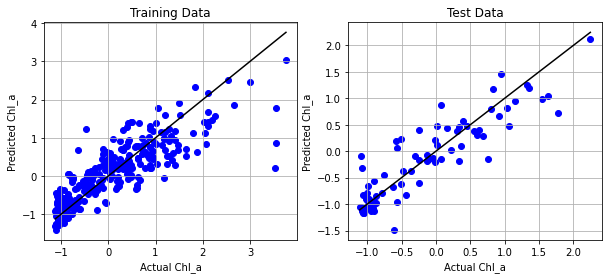

kNN
  Training Time: 1.08 ms
  Best cross-validation score (R2) : 0.67454
  Best cross-validation score (MSE): 0.32528
  Performance on train data (R2) :  0.72165
  Performance on train data (MSE):  0.27835
  Performance on test data (R2)  :  0.78791
  Performance on test data (MSE) :  0.14985
  Performance on all data (R2)   :  0.73293
  Performance on all data (MSE)  :  0.25265


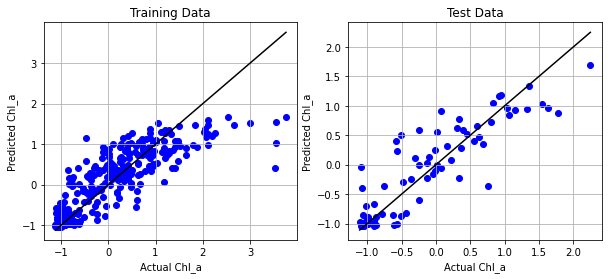

SVR
  Training Time: 27.39 ms
  Best cross-validation score (R2) : 0.65127
  Best cross-validation score (MSE): 0.34071
  Performance on train data (R2) :  0.66734
  Performance on train data (MSE):  0.33266
  Performance on test data (R2)  :  0.70545
  Performance on test data (MSE) :  0.20811
  Performance on all data (R2)   :  0.67469
  Performance on all data (MSE)  :  0.30775


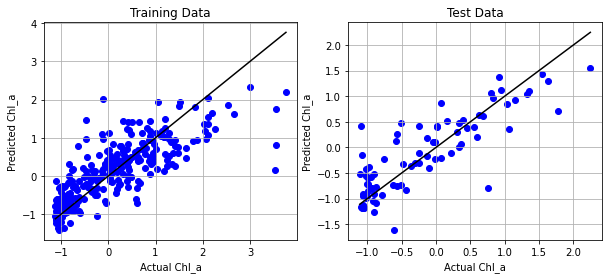

MLP
  Training Time: 320.81 ms
  Best cross-validation score (R2) : 0.70455
  Best cross-validation score (MSE): 0.29212
  Performance on train data (R2) :  0.77397
  Performance on train data (MSE):  0.22603
  Performance on test data (R2)  :  0.81820
  Performance on test data (MSE) :  0.12845
  Performance on all data (R2)   :  0.78170
  Performance on all data (MSE)  :  0.20651


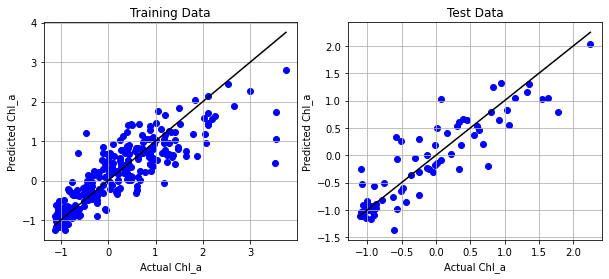

RF
  Training Time: 598.04 ms
  Best cross-validation score (R2) : 0.66087
  Best cross-validation score (MSE): 0.33748
  Performance on train data (R2) :  0.95476
  Performance on train data (MSE):  0.04524
  Performance on test data (R2)  :  0.75125
  Performance on test data (MSE) :  0.17575
  Performance on all data (R2)   :  0.92459
  Performance on all data (MSE)  :  0.07134


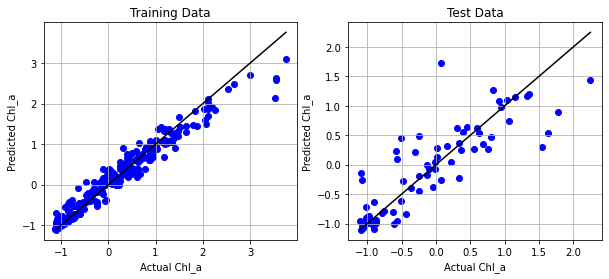

GBR
  Training Time: 41.80 ms
  Best cross-validation score (R2) : 0.66564
  Best cross-validation score (MSE): 0.33172
  Performance on train data (R2) :  0.90485
  Performance on train data (MSE):  0.09515
  Performance on test data (R2)  :  0.75370
  Performance on test data (MSE) :  0.17402
  Performance on all data (R2)   :  0.88275
  Performance on all data (MSE)  :  0.11093


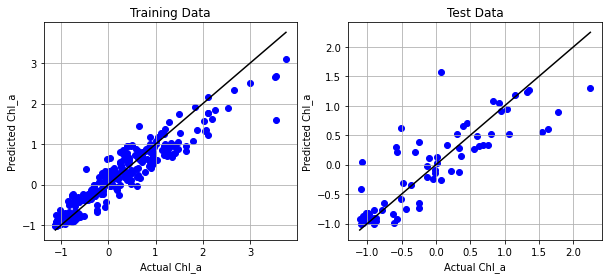

GPR
  Training Time: 8363.46 ms
  Best cross-validation score (R2) : 0.70522
  Best cross-validation score (MSE): 0.29432
  Performance on train data (R2) :  0.76828
  Performance on train data (MSE):  0.23172
  Performance on test data (R2)  :  0.82055
  Performance on test data (MSE) :  0.12679
  Performance on all data (R2)   :  0.77724
  Performance on all data (MSE)  :  0.21074


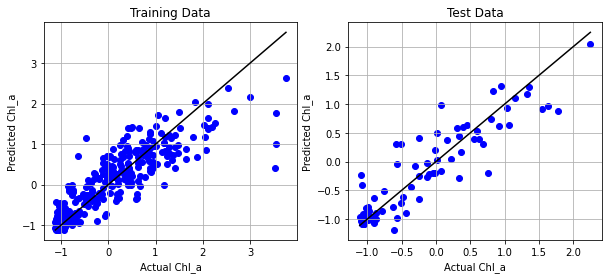

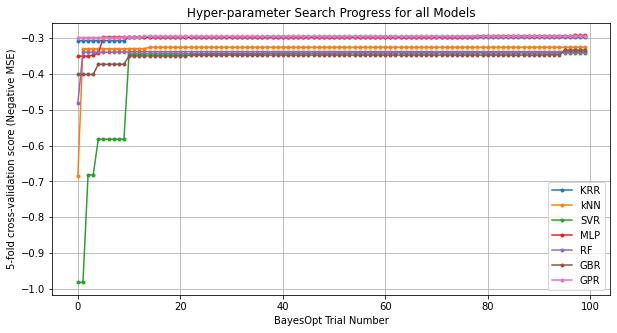

In [17]:
def compute_mse(X, y):
    scores_mse = cross_val_score(best_model, 
                                 X, y.ravel(), 
                                 cv=5, 
                                 scoring='neg_mean_squared_error')
    return -np.mean(scores_mse)

def compute_r2(X, y):
    scores_r2 = cross_val_score(best_model, 
                                X, y.ravel(), 
                                cv=5, 
                                scoring='r2')
    return np.mean(scores_r2)

mdl_names = ['KRR', 'kNN', 'SVR', 'MLP', 'RF', 'GBR', 'GPR'] 
profiles = {}
ctr = 0
for best_model in best_mdls:
    start = time()
    best_model.fit(X_train_scaled, y_train_scaled)
    
    print(f"{mdl_names[ctr]}")
    print(f"  Training Time: {(time() - start)*1000:.2f} ms")
    print("  Best cross-validation score (R2) : %.5f" % compute_r2(X_train_scaled,y_train_scaled))
    print("  Best cross-validation score (MSE): %.5f" % compute_mse(X_train_scaled,y_train_scaled))
    y_train_pred = best_model.predict(X_train_scaled)
    R2_train = r2_score(y_train_scaled,y_train_pred)
    print("  Performance on train data (R2) :  %.5f" % R2_train)
    mse_train = mean_squared_error(y_train_scaled,y_train_pred)
    print("  Performance on train data (MSE):  %.5f" % mse_train)
    y_test_pred = best_model.predict(X_test_scaled)
    R2_test = r2_score(y_test_scaled,y_test_pred)
    print("  Performance on test data (R2)  :  %.5f" % R2_test)
    mse_test = mean_squared_error(y_test_scaled,y_test_pred)
    print("  Performance on test data (MSE) :  %.5f" % mse_test)
    
    X_scaled = np.vstack((X_train_scaled, X_test_scaled))
    y_scaled = np.vstack((y_train_scaled, y_test_scaled))
    y_pred = best_model.predict(X_scaled)
    R2_all = r2_score(y_scaled, y_pred)
    print("  Performance on all data (R2)   :  %.5f" % R2_all)
    mse_all = mean_squared_error(y_scaled, y_pred)
    print("  Performance on all data (MSE)  :  %.5f" % mse_all)
    
    plt.subplots(ncols=2, figsize=(10, 4))
    plt.subplot(121)
    plt.scatter(y_train_scaled, y_train_pred, color='b')
    plt.plot([np.min(y_train_scaled), np.max(y_train_scaled)],
             [np.min(y_train_scaled), np.max(y_train_scaled)],'k')
    plt.xlabel('Actual Chl_a')
    plt.ylabel('Predicted Chl_a')
    plt.title('Training Data')
    plt.grid()
    plt.subplot(122)
    plt.scatter(y_test_scaled, y_test_pred, color='b')
    plt.plot([np.min(y_test_scaled), np.max(y_test_scaled)],
             [np.min(y_test_scaled), np.max(y_test_scaled)],'k')
    plt.xlabel('Actual Chl_a')
    plt.ylabel('Predicted Chl_a')
    plt.title('Test Data')
    plt.grid()
    plt.show()
    
    info_list = _get_optimization_history_info_list(studies[ctr], 
                                                    target=None,
                                                    target_name="Objective Value", 
                                                    error_bar=False)
    profiles[f"{mdl_names[ctr]}"] = info_list[0].best_values_info.values
    
    ctr+=1

plt.figure(figsize=(10, 5))
ctr = 0
for best_model in best_mdls:
    plt.plot(info_list[0].trial_numbers, profiles[f"{mdl_names[ctr]}"], 
             ".-", label=f"{mdl_names[ctr]}")
    ctr += 1

plt.ylabel('5-fold cross-validation score (Negative MSE)')
plt.xlabel('BayesOpt Trial Number')
plt.title('Hyper-parameter Search Progress for all Models')
plt.legend()
#plt.ylim((-1,0))
plt.grid()
plt.show()

## Shap Explanation on All Optuna Models

KernelRidge(alpha=2.7695703289883373, gamma=0.10037327015001402,
            kernel='polynomial')


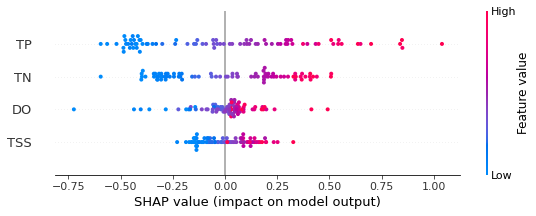

KNeighborsRegressor(n_neighbors=17)


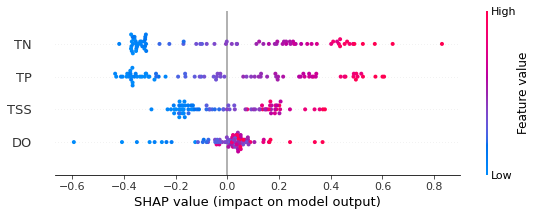

SVR(C=28.309720277666, degree=1, epsilon=0.423561235818907,
    gamma=2.5775432526997486, kernel='linear')


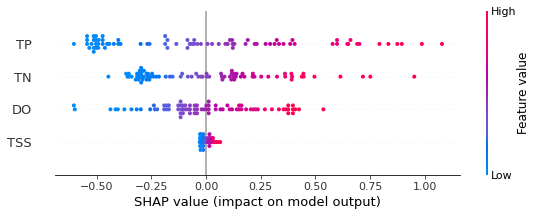

MLPRegressor(hidden_layer_sizes=(94, 73),
             learning_rate_init=0.0005632617571287851, max_iter=100,
             random_state=1)


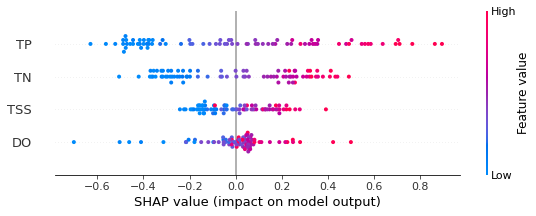

RandomForestRegressor(max_depth=18, n_estimators=200, random_state=42)


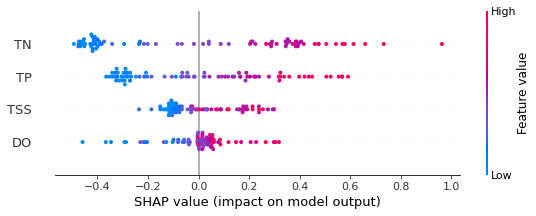

GradientBoostingRegressor(max_depth=4, n_estimators=29)


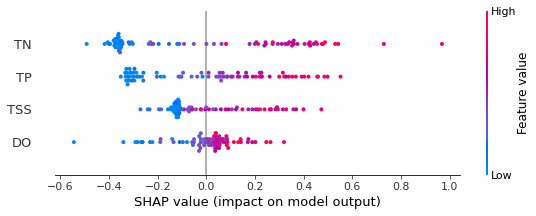

GaussianProcessRegressor(alpha=0.3279976206586827,
                         kernel=WhiteKernel(noise_level=7.18) + Matern(length_scale=0.14, nu=2),
                         n_restarts_optimizer=10)


Exact explainer: 81it [00:17,  2.07it/s]                                                                                  


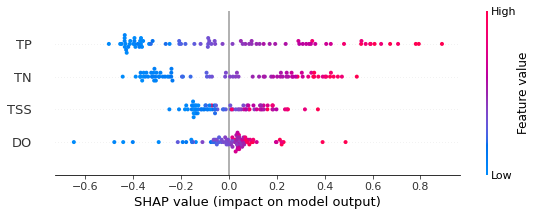

In [18]:
import shap

for best_model in best_mdls:
    print(best_model)
    shap_values = shap.KernelExplainer(best_model.predict,X_test_scaled)
    background = shap.maskers.Independent(X_test_scaled, max_samples=1000)
    explainer = shap.Explainer(best_model.predict, background)
    shap_values = explainer(X_test_scaled)

    # Plot the feature importance using SHAP
    shap.summary_plot(shap_values, X_test_scaled, 
                      feature_names=data3.columns.values[2:-1])

## Robustness Analysis due to Imperfect Measurements (using Monte Carlo)

KernelRidge(alpha=2.7695703289883373, gamma=0.10037327015001402,
            kernel='polynomial')
Original:
  Performance on train data (R2): 0.74524
  Performance on test data (R2): 0.80791


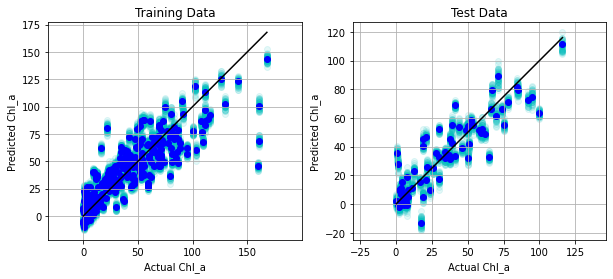

KNeighborsRegressor(n_neighbors=17)
Original:
  Performance on train data (R2): 0.72165
  Performance on test data (R2): 0.78791


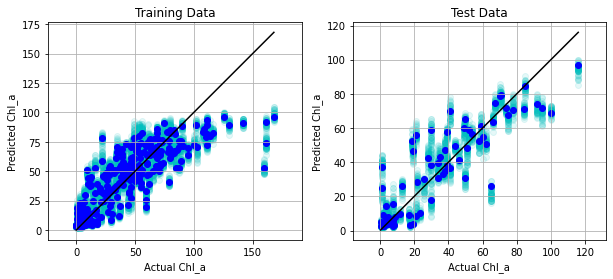

SVR(C=28.309720277666, degree=1, epsilon=0.423561235818907,
    gamma=2.5775432526997486, kernel='linear')
Original:
  Performance on train data (R2): 0.66734
  Performance on test data (R2): 0.70545


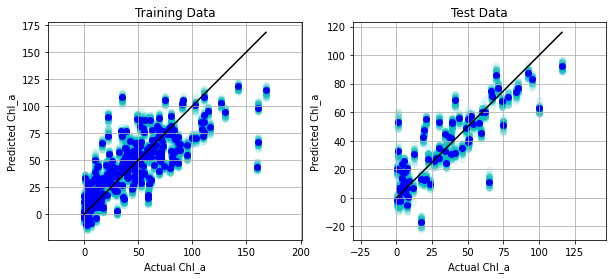

MLPRegressor(hidden_layer_sizes=(94, 73),
             learning_rate_init=0.0005632617571287851, max_iter=100,
             random_state=1)
Original:
  Performance on train data (R2): 0.77397
  Performance on test data (R2): 0.81820


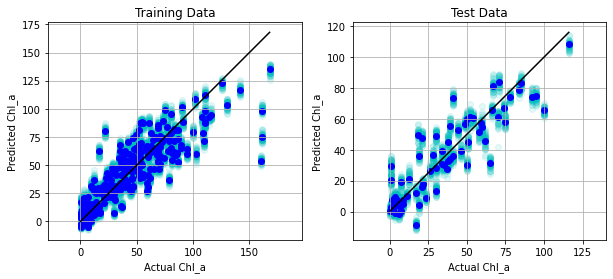

RandomForestRegressor(max_depth=18, n_estimators=200, random_state=42)
Original:
  Performance on train data (R2): 0.95476
  Performance on test data (R2): 0.75125


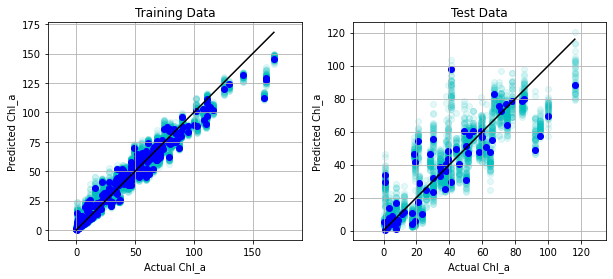

GradientBoostingRegressor(max_depth=4, n_estimators=29)
Original:
  Performance on train data (R2): 0.90485
  Performance on test data (R2): 0.75552


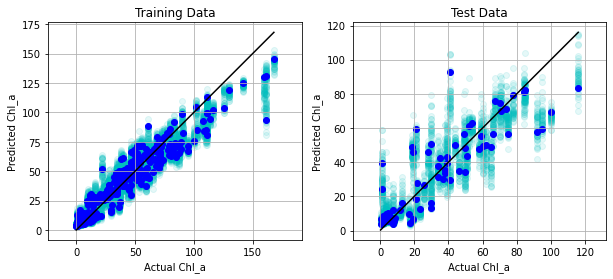

GaussianProcessRegressor(alpha=0.3279976206586827,
                         kernel=WhiteKernel(noise_level=7.18) + Matern(length_scale=0.14, nu=2),
                         n_restarts_optimizer=10)
Original:
  Performance on train data (R2): 0.76828
  Performance on test data (R2): 0.82055


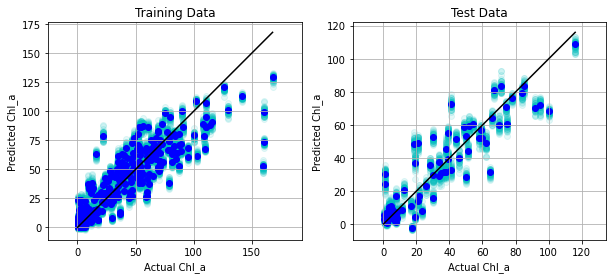

Total Runtime for Robustness Analysis: 550.9925 sec


In [19]:
N = 50
ctr = 0
R2_train_all = np.zeros((N+1,7))
R2_test_all = np.zeros((N+1,7))
start = time()

for best_model in best_mdls:
    
    print(best_model)
    mdl = best_model.fit(X_train_scaled, y_train_scaled)
    y_train = mdl.predict(X_train_scaled)
    y_test = mdl.predict(X_test_scaled)
    R2_train = r2_score(y_train_scaled,y_train)
    R2_test = r2_score(y_test_scaled,y_test)
    print("Original:")
    print("  Performance on train data (R2): %.5f" % R2_train)
    print("  Performance on test data (R2): %.5f" % R2_test)
    y_train_ = scaler_y.inverse_transform(y_train.reshape(-1,1))
    y_test_ = scaler_y.inverse_transform(y_test.reshape(-1,1))

    y_train_collect = y_train_
    y_test_collect = y_test_
    R2_train_collect = R2_train
    R2_test_collect = R2_test
    y_train_, y_test_ = y_train_.ravel(), y_test_.ravel()

    for i in range(N):
        np.random.RandomState(0)
        noise_train = np.random.normal(0,0.1,X_train_scaled.shape)
        noise_test = np.random.normal(0,0.1,X_test_scaled.shape)
        mdl_noise = best_model.fit(X_train_scaled + noise_train, y_train_scaled)
        y_train2 = mdl_noise.predict(X_train_scaled + noise_train)
        y_test2 = mdl_noise.predict(X_test_scaled + noise_test)
        R2_train2 = r2_score(y_train_scaled,y_train2)
        R2_test2 = r2_score(y_test_scaled,y_test2)
        R2_train_collect = np.hstack((R2_train_collect,R2_train2))
        R2_test_collect = np.hstack((R2_test_collect,R2_test2))
        y_train2_ = scaler_y.inverse_transform(y_train2.reshape(-1,1))
        y_test2_ = scaler_y.inverse_transform(y_test2.reshape(-1,1))
        y_train_collect = np.hstack((y_train_collect,y_train2_))
        y_test_collect = np.hstack((y_test_collect,y_test2_))

    y_train_true = scaler_y.inverse_transform(y_train_scaled.reshape(-1,1)).ravel()
    y_test_true = scaler_y.inverse_transform(y_test_scaled.reshape(-1,1)).ravel()
    R2_train_all[:,ctr] = R2_train_collect
    R2_test_all[:,ctr] = R2_test_collect
    ctr += 1

    # Sort all y according to true values
    train_id = np.argsort(y_train_true)
    test_id = np.argsort(y_test_true)
    y_train_true = y_train_true[train_id]
    y_test_true = y_test_true[test_id]
    y_train_ = y_train_[train_id]
    y_test_ = y_test_[test_id]
    y_train_collect = y_train_collect[train_id,:]
    y_test_collect = y_test_collect[test_id,:]

    plt.subplots(ncols=2, figsize=(10, 4))
    plt.subplot(121)
    for i in range(N):
        plt.scatter(y_train_true, y_train_collect[:,i], color='c', alpha=0.1)
    plt.scatter(y_train_true, y_train_, color='b')
    plt.plot([np.min(y_train_true), np.max(y_train_true)],
             [np.min(y_train_true), np.max(y_train_true)],'k')
    plt.xlabel('Actual Chl_a')
    plt.ylabel('Predicted Chl_a')
    plt.title("Training Data")
    plt.axis('equal')
    plt.grid()
    plt.subplot(122)
    for i in range(N):
        plt.scatter(y_test_true, y_test_collect[:,i], color='c', alpha=0.1)
    plt.scatter(y_test_true, y_test_, color='b')
    plt.plot([np.min(y_test_true), np.max(y_test_true)],
             [np.min(y_test_true), np.max(y_test_true)],'k')
    plt.xlabel('Actual Chl_a')
    plt.ylabel('Predicted Chl_a')
    plt.title(f"Test Data")
    plt.axis('equal')
    plt.grid()
    plt.show()
    
total_time = time()-start
print("Total Runtime for Robustness Analysis: %.4f sec" % total_time)

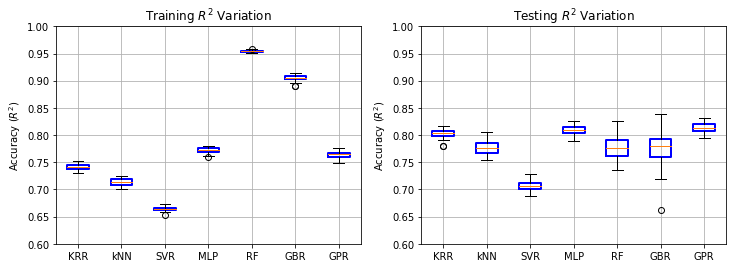

,Model,Train Medians,Test Medians
0,KRR,0.741408,0.803745
1,kNN,0.713983,0.776082
2,SVR,0.664620,0.707147
3,MLP,0.773198,0.808931
4,RF,0.954627,0.775933
5,GBR,0.905276,0.779386
6,GPR,0.764416,0.813242


In [21]:
plt.subplots(ncols=2, figsize=(12, 4))
plt.subplot(121)
boxprops = dict(linewidth=2, color='b')
plt.boxplot(R2_train_all, boxprops=boxprops)
plt.title('Training $R^2$ Variation')
plt.xticks(np.arange(7)+1,["KRR","kNN","SVR","MLP","RF","GBR","GPR"])
plt.ylim(0.6, 1.00)
plt.ylabel('Accuracy ($R^2$)')
plt.grid()
plt.subplot(122)
plt.boxplot(R2_test_all, boxprops=boxprops)
plt.title('Testing $R^2$ Variation')
plt.xticks(np.arange(7)+1,["KRR","kNN","SVR","MLP","RF","GBR","GPR"])
plt.ylim(0.6, 1.00)
plt.ylabel('Accuracy ($R^2$)')
plt.grid()
plt.show()

train_med = np.median(R2_train_all,axis=0)
test_med = np.median(R2_test_all,axis=0)
rob_pd = pd.DataFrame({"Model": mdl_names, "Train Medians": train_med, "Test Medians": test_med})
rob_pd.head(7)